<!-- ---
reviewed_on: "2024-10-30"
--- -->

# Second control

## Import necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

## Loading the dataset

In [2]:
from torchvision import datasets, transforms


trainset = datasets.CIFAR10(root="~/.pytorch/CIFAR-10", train=True, download=True,
							transform=transforms.ToTensor())
testset = datasets.CIFAR10(root="~/.pytorch/CIFAR-10", train=False, download=True,
							transform=transforms.ToTensor())

full_dataset = torch.utils.data.ConcatDataset([trainset, testset])
loader = torch.utils.data.DataLoader(full_dataset, batch_size=5000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
	images = images.view(images.size(0), images.size(1), -1) # (5000, 3, 1024)

	mean += images.mean(2).sum(0) # (5000, 3) -> (3)
	std += images.std(2).sum(0) # (5000, 3) -> (3)
	total_images += images.size(0)

mean /= total_images
std /= total_images

print(f"mean: {mean} std: {std}")

mean: tensor([0.4919, 0.4827, 0.4472]) std: tensor([0.2022, 0.1994, 0.2010])


In [4]:
from torchvision import datasets, transforms


transform = transforms.Compose([transforms.ToTensor(),
								transforms.Normalize((0.4919, 0.4827, 0.4472),
														(0.2022, 0.1994, 0.2010)),
								])

trainset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.CIFAR10("~/.pytorch/CIFAR-10/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = [
			"airplane",
			"automobile",
			"bird",
			"cat",
			"deer",
			"dog",
			"frog",
			"horse",
			"ship",
			"truck"
		]

## Building the networks

In [6]:
import torch.nn.functional as F

In [7]:
input_size = 3072
output_size = 10

### 1

In [8]:
hidden_sizes = [512]

In [9]:
class Network_1(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(input_size, hidden_sizes[0])
		self.fc2 = nn.Linear(hidden_sizes[0], output_size)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		x = F.log_softmax(self.fc2(x), dim=1)

		return x

### 2

In [10]:
hidden_sizes = [1024, 512, 256]

In [11]:
class Network_2(nn.Module):
	def __init__(self):
		super().__init__()

		self.fc1 = nn.Linear(input_size, hidden_sizes[0])
		self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
		self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
		self.fc4 = nn.Linear(hidden_sizes[2], output_size)

	def forward(self, x):
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = F.relu(self.fc3(x))
		x = F.log_softmax(self.fc4(x), dim=1)

		return x

## Training the networks

In [12]:
def train_network(network, epochs, optimizer, learning_rate, criterion):
	optimizer = optimizer(network.parameters(), lr=learning_rate)

	for _ in range(epochs):
		running_loss = 0
		for images, labels in trainloader:
			images = images.view(images.shape[0], -1)
			optimizer.zero_grad()

			logits = network(images)
			loss = criterion(logits, labels)

			loss.backward()
			optimizer.step()

			running_loss += loss.item()
		else:
			print(f"Training loss: {running_loss / len(trainloader)}")


In [13]:
networks = [Network_1(), Network_2()]

In [ ]:
epochs = 10
optimizer = optim.Adam
learning_rate = 0.0001
criterion = nn.NLLLoss()

for network in networks:
	train_network(network, epochs, optimizer, learning_rate, criterion)

Training loss: 1.681819505246399
Training loss: 1.4760554443539866
Training loss: 1.371787110329284
Training loss: 1.2896983941345264
Training loss: 1.2138646440127927


## Training results

In [ ]:
def view_classify(img, ps, classes):
	''' Function for viewing an image and its predicted classes. '''

	# If `img` is flattened, reshape it to (3, 32, 32) for CIFAR-10 images
	if img.dim() == 2 or img.shape[1] == 3 * 32 * 32:  # Adjust size for your dataset
		img = img.view(3, 32, 32)

	# Permute dimensions to make it compatible with plt.imshow
	img = img.permute(1, 2, 0)  # [C, H, W] -> [H, W, C]
	img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

	# Convert prediction tensor to numpy for plotting
	ps = ps.data.numpy().squeeze()

	# Plot the image and the class probabilities
	fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
	ax1.imshow(img.numpy())
	ax1.axis("off")

	ax2.barh(np.arange(len(classes)), ps)
	ax2.set_aspect(0.1)
	ax2.set_yticks(np.arange(len(classes)))
	ax2.set_yticklabels(classes, size="small")
	ax2.set_title("Class probability")
	ax2.set_xlim(0, 1.1)

	plt.tight_layout()
	plt.show()

In [17]:
dataiter = iter(testloader)
images, labels = next(dataiter)

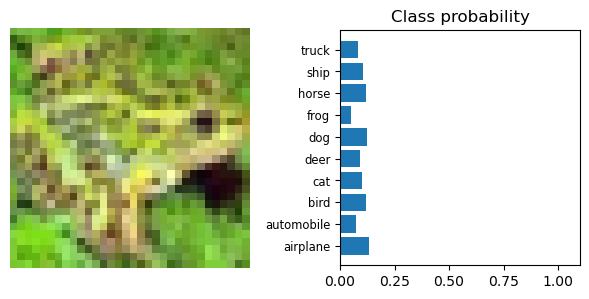

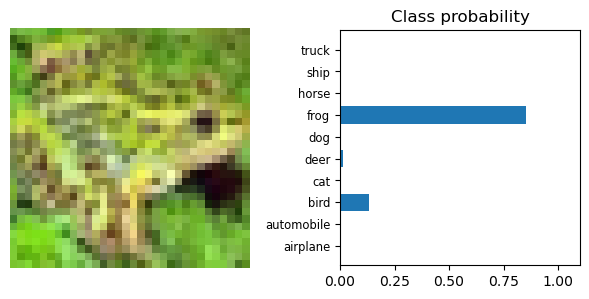

In [18]:
img = images[0].view(1, -1)
img.shape

ps_1 = torch.exp(networks[0](img))
view_classify(img, ps_1, classes)

ps_2 = torch.exp(networks[1](img))
view_classify(img, ps_2, classes)


### Best network

- Activation function: `log_softmax`.

- Criterion: negative log likelihood loss (`NLLLoss`).

- Optimizer: stochastic gradient descent (`Adam`).

    - Learning rate: $0.0001$.

- Hidden layers: `[1024, 512, 256]`.